## Semantic Textual Similarity

In [1]:
from datasets import load_dataset, concatenate_datasets
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

/research/home/he231839/honours/GitHub2/honours-project/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load Dataset

In [2]:
biosses_dataset = load_dataset('bigbio/biosses', trust_remote_code = True)

biosses_concatenated = concatenate_datasets([
    biosses_dataset['train'],
    biosses_dataset['validation'],
    biosses_dataset['test']
])

#### Convert to Pandas and Clean

In [3]:
# Concatenate Train, Validation and Test Set
biosses = biosses_concatenated.to_pandas()

# Create Mean Label across all 5 annotations
biosses['mean_label'] = biosses.iloc[:, 4:-1].mean(axis = 1)

# Normalised Mean Label for Cosine Similarity
biosses['mean_label'] = biosses['mean_label'] / 4
biosses.head()

,id,document_id,text_1,text_2,annotator_a,annotator_b,annotator_c,annotator_d,annotator_e,mean_label
0,0,1,It has recently been shown that Craf is essent...,It has recently become evident that Craf is es...,4,4,4,4,4,1.0000
1,2,3,Previous studies demonstrated that the decreas...,"In addition, genetic and functional studies su...",2,2,3,2,2,0.5625
2,3,4,"More recently, IDH mutations and resultant 2-h...",It has also been recently reported that mutati...,3,3,4,3,3,0.8125
3,4,5,Recent in vitro studies using shRNA-based appr...,Two recent studies used RNAi-mediated Tet2 kno...,3,3,4,3,3,0.8125
4,5,6,"Recently, it was reported that expression of I...",This large-scale study showed that IDH1/IDH2 m...,3,3,4,3,3,0.8125


#### Load ClinicalBERT

In [9]:
from transformers import AutoTokenizer, AutoModel

ClinicalBERT = 'medicalai/ClinicalBERT'
BERT = 'google-bert/bert-base-uncased'

tokenizer_ClinicalBERT = AutoTokenizer.from_pretrained(ClinicalBERT)
model_ClinicalBERT = AutoModel.from_pretrained(ClinicalBERT)

tokenizer_BERT = AutoTokenizer.from_pretrained(BERT)
model_BERT = AutoModel.from_pretrained(BERT)

In [5]:
def mean_pooling(inputs, model):
    with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_state = outputs.last_hidden_state
            
    attention_mask = inputs['attention_mask']
    mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    sum_embeddings = torch.sum(last_hidden_state * mask_expanded, 1)
    sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
    mean_pooling = sum_embeddings / sum_mask  # shape: [batch_size, hidden_dim]

    return mean_pooling


In [6]:
def cosine_similarity(tokenizer, model, row):
    input1 = tokenizer(row['text_1'], return_tensors = 'pt', padding = False)
    input2 = tokenizer(row['text_2'], return_tensors = 'pt', padding = False)

    embeddings = [mean_pooling(inputs, model) for inputs in [input1, input2]]

    cos_sim = torch.nn.functional.cosine_similarity(embeddings[0], embeddings[1])

    return cos_sim.item()

        



In [12]:
biosses['ClinicalBERT_SIM'] = biosses.apply(lambda row: cosine_similarity(tokenizer_ClinicalBERT, model_ClinicalBERT, row), axis = 1)
biosses['BERT_SIM'] = biosses.apply(lambda row: cosine_similarity(tokenizer_BERT, model_BERT, row), axis = 1)

In [15]:
biosses.to_csv('biosses_data.csv')

In [13]:
biosses.head()

,id,document_id,text_1,text_2,annotator_a,annotator_b,annotator_c,annotator_d,annotator_e,mean_label,ClinicalBERT_SIM,BERT_SIM
0,0,1,It has recently been shown that Craf is essent...,It has recently become evident that Craf is es...,4,4,4,4,4,1.0000,0.825240,0.849393
1,2,3,Previous studies demonstrated that the decreas...,"In addition, genetic and functional studies su...",2,2,3,2,2,0.5625,0.805170,0.819069
2,3,4,"More recently, IDH mutations and resultant 2-h...",It has also been recently reported that mutati...,3,3,4,3,3,0.8125,0.926234,0.946986
3,4,5,Recent in vitro studies using shRNA-based appr...,Two recent studies used RNAi-mediated Tet2 kno...,3,3,4,3,3,0.8125,0.888762,0.934582
4,5,6,"Recently, it was reported that expression of I...",This large-scale study showed that IDH1/IDH2 m...,3,3,4,3,3,0.8125,0.907551,0.917922


In [133]:
def plot_sim(biosses):
    plt.hist(biosses['ClinicalBERT_SIM'], bins = 50)
    plt.xlabel('Cosine Similarity')
    plt.show()

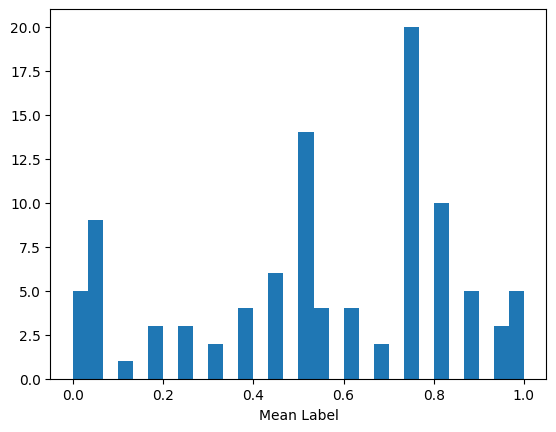

In [134]:
plt.hist(biosses['mean_label'], bins = 30)
plt.xlabel('Mean Label')
plt.show()

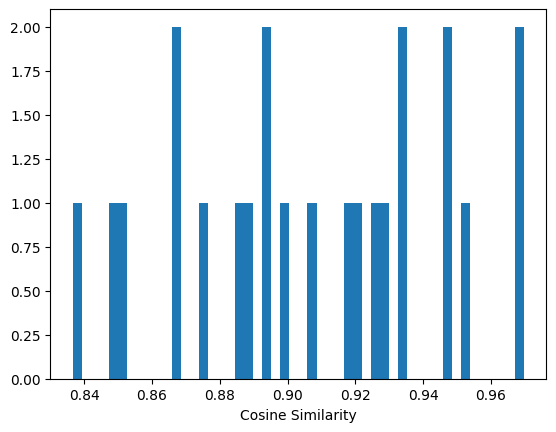

In [135]:
# Mean Values between 0.75 and 1
plot_sim(biosses[(biosses['mean_label'] > 0.75) & (biosses['mean_label'] <= 1)])

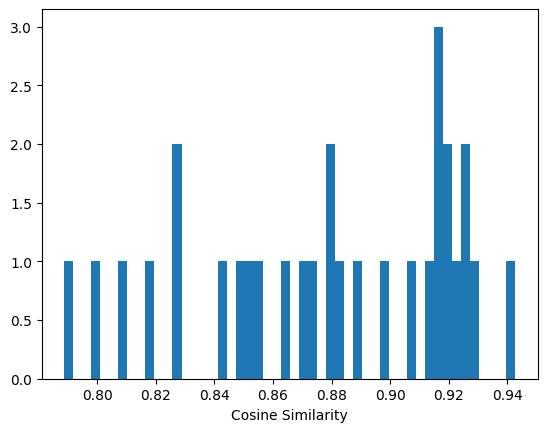

In [136]:
# Mean Values between 0.5 and 0.75
plot_sim(biosses[(biosses['mean_label'] > 0.5) & (biosses['mean_label'] <= 0.75)])

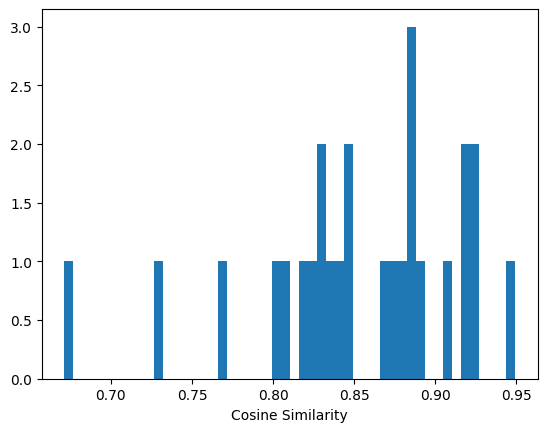

In [137]:
# Mean Values between 0.25 and 0.5
plot_sim(biosses[(biosses['mean_label'] > 0.25) & (biosses['mean_label'] <= 0.5)])

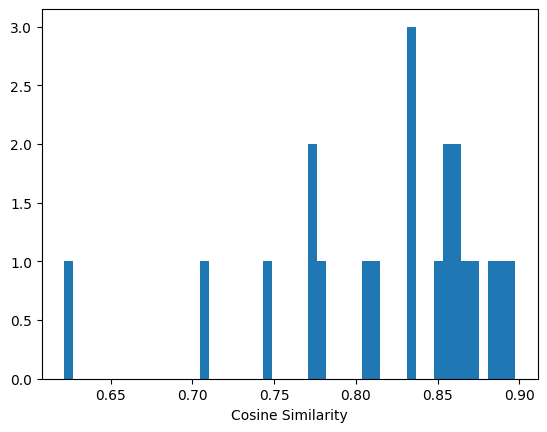

In [138]:
# Mean Values between 0.0 and 0.25
plot_sim(biosses[biosses['mean_label'] <= 0.25])